In [1]:
# 9-Compartment___Network
# Philip Cherian; 4th September, 2020

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

Model details found [here](https://covid-measures.github.io/). Schematic for the model:

<img src="../images/model_schematic.png" alt="Drawing" style="width: 600px;"/>

Let's start off with the following parameters:
\begin{equation}
    \begin{aligned}
        \dot{S} &= - \beta \frac{S}{N} \left(C_P I_P + C_A I_A + C_S I_S + C_M I_M \right)\\
        \dot{E} &=  \beta \frac{S}{N} \left(C_P I_P + C_A I_A + C_S I_S + C_M I_M  \right) - \gamma E \\
        \dot{I_P} &= (1 - \alpha) \gamma E - \lambda_P I_P \\
        \dot{I_A} &= \alpha \gamma E - \lambda_A I_A\\
        \dot{I_S} &= (1-\mu) \lambda_P I_P - \lambda_S I_S\\
        \dot{I_M} &= \mu \lambda_P I_P - \lambda_M I_M\\
        \dot{H} &= \lambda_S I_S - \rho H \\
        \dot{R} &= \lambda_M I_M + \lambda_A I_A + (1 - \delta) \rho H\\
        \dot{D} &= \delta \rho H
    \end{aligned}
\end{equation}


In [2]:
# Parameters for the problem ###############################################

pars = [0.2,0.2,0,0.9,0,0,0,0.99,0,0]
Cpars= [1,0,0,0]

# OLD 9-compartment PARAMETERS

#pars = [0.5, 0.192, 0.33, 0.5,   0.1428, 0.1736, 0.1428, 0.956, 0.068, 0.2 ]
     # [beta,gamma,alpha,lambdaP,lambdaA,lambdaS,lambdaM,  mu,  rho,  delta]

#Cpars= [1, 0.66, 1, 1]
     # [Cp, Ca, Cs, Cm]

#pops = [1000,  0 ,  0 ,  0 ,  0 ,  0 , 0 ,  0 , 10000]
     # [ E0,  IP0, IA0, IS0, IM0, IH0, R0,  D0,  N]
    
#real_fam_dist=[89703, 180455, 314096, 579496, 451932, 289265, 327046/4, 327046/4, 327046/4 , 327046/4,  40397/4, 40397/4, 40397/4, 40397/4, 10855]
       # [   1 ,       2 ,     3,      4 ,     5,     6,     7,       8,        9,      10,         11,        12,      13,     14,     15]

fam_dist = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    
p=0.99

labels = [ "E","IP","IA","IS","IM","H","R","D","N"]



# Family size distribution

Let's start by first creating a distribution of family sizes for Delhi NCT from data `fam_dist` (Census 2011). We define a `get_fam()` function that returns an arbitrary family size satisfying the above distribution. To check that it works, we run it many times and see that it reproduces the original distribution.

In [3]:
def create_fam(ID,n,pops,n_networks):               # Create family of size n, with individuals in states defined 
                                                    # by pops
        
        labels = [ "E","IP","IA","IS","IM","H","R","D","N"]
        
        if(len(pops)!=len(labels)):
            print("Something's wrong, pops should look like "+str(labels))
            print("Running anyway, at your own peril.")
        
        if pops[-1]!=n:
            print("Something's wrong, family size and number of members don't match!")
            return False
        
        family = [['S',ID]]*n                        # Initialise family to all susceptible individuals
        
        counter = 0
        for num in range(0,len(pops)-1):             # Start assigning individuals to family.
            for i in range(0,pops[num]):
                r = random.randint(0,n_networks)     # Each person assigned to random network
                family[counter]=[labels[num], ID, r] # Each individual is of the form ['label', ID, 'Network number']
                counter = counter + 1
        
        # Adding network numbers for remaining (susceptible) individuals
        
        while(counter<len(family)):
            r = random.randint(0,n_networks)   # Each person assigned to random network
            family[counter]=["S", ID, r]         # Each individual is of the form ['label', ID, 'Network number']
            counter = counter + 1
            
        return family
            
        
                                                  

### COULD BE IMPROVED, currently can only create families with one exposed individual, should generalise #######
###                    to include probability distribution of finding exposed, infected, etc.            #######
            
def get_fam(ID,n_networks):                        # Creates a family from a probabilty distribution (Census 2011)
    totalPop = np.sum(fam_dist)                    # That has ONE EXPOSED INDIVIDUAL (this can be improved)
    w = np.array(fam_dist)/totalPop
    
    num = np.zeros(len(fam_dist),int)
    r = np.random.random()
    
    if(r < w[0]):
        return create_fam(ID,1,[1,0,0,0,0,0,0,0,1],n_networks)
    else:
        add = w[0]
        for j in range(1,len(fam_dist)):
            add = add + w[j]
            if(r<add):
                return create_fam(ID,j+1,[1,0,0,0,0,0,0,0,j+1],n_networks)
                break

In [4]:
##### ONLY REQUIRED TO TEST get_fam() ###############
# _totalPop = np.sum(fam_dist)
# _w = np.array(fam_dist)/_totalPop

# total_nums =[]
# n_iter = 10000
# for i in range(0,n_iter):
#     total_nums.append(len(get_fam(1)))
    
# nn = np.zeros(15,int)
# total_nums = np.array(total_nums)
# for i in range(1,16):
#     nn[i-1] = len(total_nums[total_nums==i])

# plt.scatter(range(0,len(fam_dist)),nn/n_iter,label="Generated Distribution")
# plt.scatter(range(0,len(fam_dist)),_w,marker='x', label="Census Data")
# plt.legend()
# #plt.savefig('../images/Delhi_NCT_population_dist.png')
# plt.show()
#########################################################

In [5]:
### Creating a list of families each with one EXPOSED individual #######################################

n_networks = 100

n_population = 10000

samplePopulation = n_population                  # Number of people we're distributing into families

ID = 0                                           # Counter to store ID number per family
 
fams = []                                        # List (jagged) containing families

while(samplePopulation>0):
    temp_fam = get_fam(ID,n_networks)
    
    old_pop = samplePopulation
    
    samplePopulation = samplePopulation-len(temp_fam)
    
    if(samplePopulation>0):
        fams.append(temp_fam)
    else:                                         # If more people are asked for than exist in population, make
        fams.append(create_fam(ID,                # a family out of those who remain
                               old_pop,
                               [1,0,0,0,0,0,0,0,old_pop],
                               n_networks))
    
    ID = ID + 1                         # Increment ID

n_families = len(fams)

In [6]:
## Function to count numbers of individuals in different states in population, given a list of families

def count_families(fam_list):
    
    nums = np.zeros(len(labels),int)
    
    #sizes_array = np.zeros(16,int)
    
    for family in fam_list:
        np_family = np.array(family)
        
        size = len(np_family)
        #sizes_array[size] += 1
        
        for i in range(0,len(nums)-1):
            nums[i] = nums[i] + len(np_family[np.where(np_family==labels[i])])  
        
        nums[len(nums)-1] = nums[len(nums)-1] + size
    
    return nums.tolist()#,sizes_array


In [7]:
def Gillespie_Run(pars, Cpars, group,T):
    group = np.array(group,dtype="object")
    #print("Starting Gillespie")
    # Getting numbers of different cases ###
    
    n_S = len(np.where(group=='S')[0])
    n_E = len(np.where(group=='E')[0])
    n_IP = len(np.where(group=='IP')[0])
    n_IA = len(np.where(group=='IA')[0])
    n_IS = len(np.where(group=='IS')[0])
    n_IM = len(np.where(group=='IM')[0])
    n_H = len(np.where(group=='H')[0])
    n_R = len(np.where(group=='R')[0])
    n_D = len(np.where(group=='D')[0])
    
    #print(group)
    N = len(group[:,0])
    
    
    # Parameters of the problem ############
    
    beta    = pars[0]
    gamma   = pars[1]
    alpha   = pars[2]
    lambdaP = pars[3]
    lambdaA = pars[4]
    lambdaS = pars[5]
    lambdaM = pars[6]
    mu      = pars[7]
    rho     = pars[8]
    delta   = pars[9]
    
    # Contact Parameters ###################
    
    Cp = Cpars[0]
    Ca = Cpars[1]
    Cs = Cpars[2]
    Cm = Cpars[3]
    
    #########################################
    
    _t = 0.0       # float; start time

    V = 1          # float; spatial parameter (NOT "N"!)
    
    W = 0
    
    #########################################
    # Initialize results list ###############

    S  = []
    E  = []
    IP = []
    IA = []
    IS = []
    IM = []
    H  = []
    R  = []
    D  = []
    t  = []

    S.append(n_S)
    E.append(n_E)
    IP.append(n_IP)
    IA.append(n_IA)
    IS.append(n_IS)
    IM.append(n_IM)
    H.append(n_H)
    R.append(n_R)
    D.append(n_D)
    t.append(_t)

    #########################################

    
    # Loop to compute results at every time-step

    while _t < T:

        ### DECIDE HOW TO END ####################
        if n_IP != 0:                           # If a single pre-symptomatic appears
          
            r,c = np.where(group=='IP')         # Find all pre-symptomatic individuals
          
            for k in range(0,len(r)):           # For each individual
                test = random.uniform(0,1)      # Perform a test with random uniform distribution
                
                if(test<p):                     # If test is positive
                    #print(group)
                    group[r[k],2]=0             # Keep the individual at home (network 0)
            
#             group[:,0] = 'H'                  # OLD STUFF: USED TO HOSPITALISE EVERYONE!
#             S.append(0)
#             E.append(0)
#             IP.append(0)
#             IA.append(0)
#             IS.append(0)
#             IM.append(0)
#             H.append(N)
#             R.append(0)
#             D.append(0)
#             t.append(_t -np.log(random.uniform(0.0, 1.0)) / W )
            break                                     # Stop the loop if one presymptomatic case appears
            
        elif n_E + n_IA + n_IP == 0:                  # No one left to infect anyone
            break                                     # Stop the loop as no more infections possible
        
        
        w1 = beta * n_S * ((Cp*n_IP + Ca*n_IA + Cs*n_IS + Cm*n_IM) / V +0.01)
        w2 = (1 - alpha) * gamma * n_E
        w3 = alpha * gamma * n_E
        w4 = (1 - mu) * lambdaP * n_IP
        w5 = mu * lambdaP * n_IP
        w6 = lambdaA * n_IA
        w7 = lambdaS * n_IS
        w8 = lambdaM * n_IM
        w9 = (1 - delta) * rho * n_H
        w10= delta * rho * n_H
        
        W = w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10
        
        dt = -np.log(random.uniform(0.0, 1.0)) / W             # Choose exponentially distributed time interval
        _t = _t + dt                                           # Increment time
        
        
        r = random.uniform(0.0, 1.0)                           # Uniformly distributed random variable to choose 
                                                               # which transition occurs
        if r < w1 / W:
            r,c = np.where(group=='S')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='E'
            n_S = n_S - 1
            n_E = n_E + 1
        elif r < (w1+w2) / W:
            r,c = np.where(group=='E')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='IP'
            n_E  = n_E - 1
            n_IP = n_IP + 1
        elif r < (w1+w2+w3) / W:
            r,c = np.where(group=='E')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='IA'
            n_E   = n_E - 1
            n_IA  = n_IA + 1
        elif r < (w1+w2+w3+w4) / W:
            r,c = np.where(group=='IP')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='IS'
            n_IP = n_IP - 1 
            n_IS = n_IS + 1
        elif r < (w1+w2+w3+w4+w5) / W:
            r,c = np.where(group=='IP')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='IM'
            n_IP = n_IP - 1
            n_IM = n_IM + 1
        elif r < (w1+w2+w3+w4+w5+w6) / W:
            r,c = np.where(group=='IA')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='R'
            n_IA = n_IA - 1
            n_R  = n_R + 1
        elif r < (w1+w2+w3+w4+w5+w6+w7) / W:
            r,c = np.where(group=='IS')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='H'
            n_IS = n_IS - 1
            n_H  = n_H + 1
        elif r < (w1+w2+w3+w4+w5+w6+w7+w8) / W:
            r,c = np.where(group=='IM')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='R'
            n_IM = n_IM - 1
            n_R  = n_R + 1
        elif r < (w1+w2+w3+w4+w5+w6+w7+w8+w9) / W:
            r,c = np.where(group=='H')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='R'
            n_H  = n_H - 1
            n_R  = n_R + 1
        else:
            r,c = np.where(group=='H')
            k = random.randint(0,len(r)-1)
            group[r[k],c[k]]='D'
            n_H = n_H - 1
            n_D = n_D + 1

        S.append(n_S)
        E.append(n_E)
        IP.append(n_IP)
        IA.append(n_IA)
        IS.append(n_IS)
        IM.append(n_IM)
        H.append(n_H)
        R.append(n_R)
        D.append(n_D)
        t.append(_t)

    return group.tolist() #t,np.array(S),np.array(E),np.array(IP),np.array(IA),np.array(IS),np.array(IM),np.array(H),np.array(R), np.array(D), group

In [8]:
time_array = []

output = []

T_fam = 1  # Time spent with family
T_net = 1  # Time spent in network

T_total = 5*30 # 3 months

time = 0



while(time < T_total):
    
    networks = []
    temp_fams= []
    
    #print(fams[0])

    for i in range(0,n_networks+1):                       # Create a bunch of empty networks
        networks.append([])
    
    for i in range(0,n_families):                         # Create a bunch of empty families (for temp storage)
        temp_fams.append([])

    #### RUN GILLESPIE FOR FAMILIES ########################
    
    for i in range(0,len(fams)):                           # For each family
        fams[i] = Gillespie_Run(pars,Cpars,fams[i],T_fam)  # Replace with family state after running Gillespie for T_fam

        for person in fams[i]:                             # Add family members to network
            if(person[0]=='IM'):                            # (Hospitalised are in network 0)
                networks[0].append(person)
            else:
                networks[person[2]].append(person)         # Everyon else added to their respective network 
                                                           # (People in network zero don't have a Gillespie run on them (Stay-at-homes.))
    
    time = time + T_fam                                    # Incremement time by total elapsed in family
    time_array.append(time)
    output.append(count_families(fams))
    
    #### RUN GILLESPIE FOR NETWORKS ########################
    
    for i in range(1, len(networks)):                      # Now, for each network (except network 0)
        networks[i] = Gillespie_Run(pars,Cpars,networks[i],T_net)  # Replace with network state after running Gillespie for T_net
        
        for person in networks[i]:                         # Split network back up into families
            temp_fams[person[1]].append(person)
            
    for person in networks[0]:                             # Split network[0] back into families
        temp_fams[person[1]].append(person)
    
    
    for i in range(0,len(fams)):
        if(len(fams[i])!= len(temp_fams[i])):
            print("ERROR! Temp and old families are not the same length!")
        else:
            fams[i] = temp_fams[i]
    
    time = time + T_net                                    # Incremement time by total elapsed in family
    time_array.append(time)
    output.append(count_families(fams))

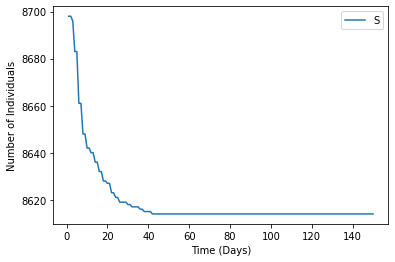

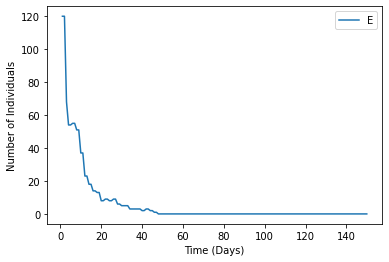

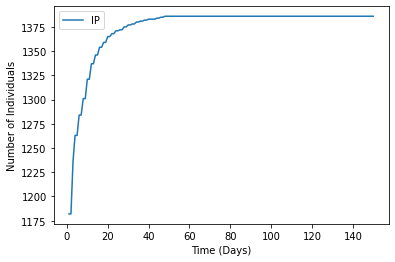

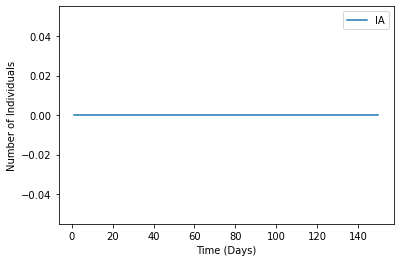

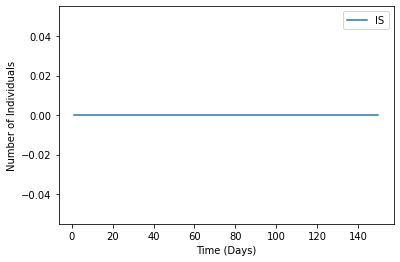

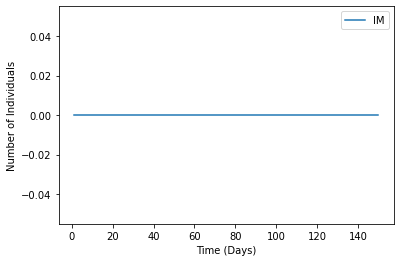

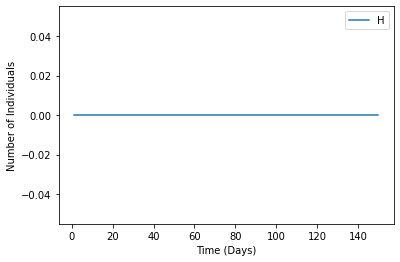

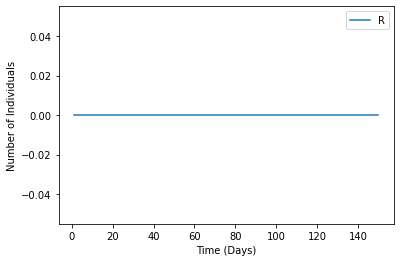

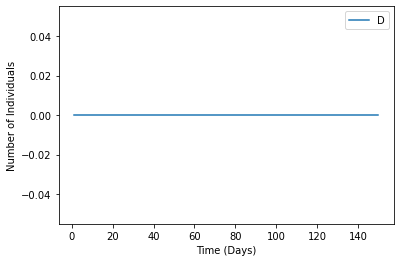

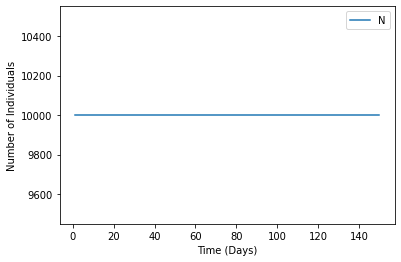

In [9]:

output = np.array(output)
susc   = np.zeros(len(output[:,0]),int)

for i in range(0,len(output)):
    susc[i] = 2*n_population - np.sum(output[i,:])

plt.plot(time_array,susc, label='S')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()
    
for i in range(0,len(labels)):
    plt.plot(time_array,output[:,i], label=labels[i])
    plt.xlabel('Time (Days)')
    plt.ylabel('Number of Individuals')
    plt.legend()
    plt.show()
